In [99]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import nltk
from sklearn.cluster import DBSCAN
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import scipy.spatial.distance
from scipy.special import softmax
from scipy.spatial.distance import cdist
from sklearn import metrics
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [100]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return None
setup_mpl()

In [101]:
def plus_plus(X, k, random_state=42):
    '''
    ##########################
    #k-means++ initialization#
    ##########################
    
    The approach:
         * 1st centroid is chosen uniformly at random from the observations.
         * Subsequently, the remaining centroids are chosen from the remaining observation with probability
           proportionally with the squared distance to the closest existing centroid
    
    Parameters:
        * X : Observations, X \in R^{observations x features}
        * k : Number of centroids
    
    by Christian Djurhuus
    '''
    np.random.seed(random_state)
    
    # Allocating memory
    centroids = np.zeros((k, X.shape[1]))
    
    # Sampling first centroid uniformly at random from observations
    indicies = [i for i in range(X.shape[0])]
    first_idx = np.random.choice(indicies, size=1)
    indicies.remove(first_idx)
    centroids[0,:] = X[first_idx, :]

    # Determining remaining number of centroids:
    for i in range(1,k):
        print(f'Number of centroids defined: {i+1}')
        # Compute distance between all observations and existing centroids
        pair_dist = (((np.expand_dims(X[indicies,:], 1)-centroids[:i,:]+1e-06)**2).sum(-1))
        #pair_dist = cdist(X[indicies,:], centroids[:i,:], metric='euclidean')

        # Probabilities:
        if pair_dist.ndim==1:
            #only one centroid available. Hence, dist to nearest centroid is just pair dist
            dist = pair_dist
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()
        else:
            dist = pair_dist.min(axis=1)
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()


        #Selecting one of the remaining observations
        selected_idx = np.random.choice(indicies,size=1, p=probs)
        indicies.remove(selected_idx)
        centroids[i, :] = X[selected_idx, :]
    
    return centroids

In [183]:
def kmeans(X, k, random_state=42, tot=1e-4, n_init=10):
    #Substracting mean of data
    #X -= X.mean(axis=0)

    best_inertia = 1e6

    #run n_init number of the kmeans algorithm and return clusters with minimum inertia
    for i in range(1, n_init+1):
        print(f'Kmeans run no. {i}')
        
        #Determining centroids using kmeans++
        centroids = plus_plus(X=X, k=k, random_state=i*random_state)

        #initial placeholder
        prev_centroids = np.zeros(centroids.shape)
        assignments = np.zeros(X.shape[0])

        #Run until convergence
        itr = 1
        diff = 1e5
        while not np.allclose(prev_centroids, centroids):
            print(f'Iteration number: {itr} - diff {diff}')
            prev_diff = diff
            prev_assignments = assignments

            #Using broadcasting to compute pairwise distances between observations and centroids
            dists=((np.expand_dims(X, 1)-centroids+1e-06)**2).sum(-1)**0.5
            assignments = dists.argmin(axis=1)
            prev_centroids = centroids.copy()

            #Update centroid position
            for idx in range(k):
                centroids[idx, :] = X[np.where(assignments==idx)].mean(axis=0)

            itr += 1


            #Distance between previous centroids and current
            diff = ((((prev_centroids - centroids + 1e-6)**2).sum(-1))**0.5).sum()

            #Early stopping when converged
            if np.array_equal(prev_assignments, assignments): #Check for strict convergence
                break

            if diff < tot: #Check for loose convergence
                break

        #Computing inertia
        #Sum of squared distance between each sample and its assigned center.
        #TODO: use broadcasting instead of for loop
        inertia = 0
        for idx in range(k):
            #inertia_dist = X[np.where(assignments==idx)] - centroids[idx, :]
            #inertia += (inertia_dist.T@inertia_dist).sum()
            inertia += np.sum((np.expand_dims(X[np.where(assignments==idx)],1) - centroids[idx, :]) ** 2, axis=0).sum() #squared dist
            #inertia += np.linalg.norm(X[np.where(assignments==idx)] - centroids[idx, :])**2

        if inertia < best_inertia:
            best_inertia = inertia
            print(f'Current best inertia: {best_inertia}')
            best_assignments = assignments
            best_centroids = centroids

    return best_assignments, best_centroids, best_inertia


In [103]:
def performance_metrics(X, assign, labels):
    print(f'ARI: {metrics.adjusted_rand_score(labels, assign):.3f}')
    print(f'NMI: {metrics.adjusted_mutual_info_score(labels, assign):.3f}')
    print(f'DBI: {metrics.davies_bouldin_score(X, assign):.3f}')
    print('\n')
    return None

In [104]:
df = pd.read_csv('CleanData/clean_completeSpamAssassin.csv')
df['tokens'] = df['tokens'].apply(literal_eval)
df.head()

,text,label,tokens,str_tokens
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,spam,"[save, life, insur, spend, life, quot, save, e...",save life insur spend life quot save ensur fam...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...
3,##############################################...,spam,"[adult, club, offer, free, membership, instant...",adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,spam,"[thought, might, like, slim, guarante, lose, l...",thought might like slim guarante lose lb day u...


In [105]:
#TDIDF
def identity_tokenizer(text):
    return text

#vectorizer = TfidfVectorizer(analyzer='word',
#    tokenizer=identity_tokenizer,
#    preprocessor=identity_tokenizer,
#    token_pattern=None)

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False
                            )

vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
X = vecs

In [106]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(X)

In [107]:
# Define affinity matrix
A = similarity
#Seems to be an issue with sklearns cosine similarity
#some diag elements equal zero, which it shouldn't
#The following fixes the issue
np.fill_diagonal(A, 0.0)
row_sum = A.sum(0)
removed_idx = np.where(A.sum(0)==0)[0]
A_reduced = A[row_sum != 0, :]
A_reduced = A_reduced[:, row_sum!=0]

assert np.where(A_reduced.sum(0)==0)[0].size == 0
assert np.where(A_reduced.sum(1)==0)[0].size == 0

# Define D as a diagonal matrix where element (i,i) corresponds to the sum of ith row in A
D = np.diag(A_reduced.sum(axis=0))
D_pow = np.diag(np.power(np.diagonal(D), -0.5))
# Define L=D^{-1/2}AD^{-1/2}
L = D_pow@A_reduced@D_pow

In [108]:
# Find the k largest eigenvectors of L
eigenvals, eigenvectors = np.linalg.eigh(L)

In [177]:
k = 2
k_largest = np.argpartition(eigenvals, -k)[-k:]

In [178]:
#Create matrix X_spec = [x1,...,xk]
X_spec = eigenvectors[:, k_largest]

In [179]:
# Define Y as X row normalized
Y = X_spec/np.linalg.norm(X_spec, axis=0)

In [180]:
row_sums = np.power(X_spec, 2).sum(axis=1)
#row_sums = X_spec.sum(axis=1)
Y = (X_spec / np.power(row_sums[:, np.newaxis], 0.5))
#Y = X_spec / row_sums[:, np.newaxis]
Y = np.nan_to_num(Y)

In [223]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(Y, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.5614827815198409
Iteration number: 3 - diff 0.03160761968652769
Iteration number: 4 - diff 0.01620250063569494
Iteration number: 5 - diff 0.010797875090794388
Iteration number: 6 - diff 0.00393261607398897
Iteration number: 7 - diff 0.002241811326435103
Iteration number: 8 - diff 0.001119036558438922
Current best inertia: 375.6816673955688
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.4661905238227713
Iteration number: 3 - diff 0.14155178491120407
Iteration number: 4 - diff 0.09361974636608009
Iteration number: 5 - diff 0.05117017413471655
Iteration number: 6 - diff 0.03160761968652769
Iteration number: 7 - diff 0.01620250063569494
Iteration number: 8 - diff 0.010797875090794388
Iteration number: 9 - diff 0.00393261607398897
Iteration number: 10 - diff 0.002241811326435103
Iteration number: 11 - diff 0.001119

Iteration number: 18 - diff 0.002645253427278017
Iteration number: 19 - diff 0.000745232471940278
Iteration number: 20 - diff 0.00029796967097716373
Iteration number: 21 - diff 0.00014904708132612322
Iteration number: 22 - diff 0.00014902425222218684
Current best inertia: 104.43625252709309
Kmeans run no. 2
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.35617894876246153
Iteration number: 3 - diff 0.08636319011487621
Iteration number: 4 - diff 0.03921604077944407
Iteration number: 5 - diff 0.02403062987298723
Iteration number: 6 - diff 0.017957489159305735
Iteration number: 7 - diff 0.015316388217654207
Iteration number: 8 - diff 0.01176963904423503
Iteration number: 9 - diff 0.01147112021479342
Iteration number: 10 - diff 0.009710260108870453
Iteration number: 11 - diff 0.011172407813876656
Iteration number: 12 - diff 0.00814321651729062
Iteration number: 13 - diff 0.00708330

Iteration number: 10 - diff 0.008796558062095802
Iteration number: 11 - diff 0.008441193142388753
Iteration number: 12 - diff 0.0058256262419226195
Iteration number: 13 - diff 0.007406433224155044
Iteration number: 14 - diff 0.008714979039610857
Iteration number: 15 - diff 0.0036653675552783065
Iteration number: 16 - diff 0.004809673741906249
Iteration number: 17 - diff 0.013268884922469375
Iteration number: 18 - diff 0.007543381679202496
Iteration number: 19 - diff 0.006785922466636993
Iteration number: 20 - diff 0.0036587437595330904
Iteration number: 21 - diff 0.008277896540360784
Iteration number: 22 - diff 0.006067896633000818
Iteration number: 23 - diff 0.003277581291804005
Iteration number: 24 - diff 0.004090046861891846
Iteration number: 25 - diff 0.0040489607369927315
Iteration number: 26 - diff 0.0029617326883999992
Iteration number: 27 - diff 0.001814567306675077
Iteration number: 28 - diff 0.0017681017276930948
Iteration number: 29 - diff 0.002350066343496038
Iteration numb

Iteration number: 25 - diff 0.0028325658614068738
Iteration number: 26 - diff 0.0012716444199980933
Iteration number: 27 - diff 0.001598616182257082
Iteration number: 28 - diff 0.0015989449196138024
Iteration number: 29 - diff 0.002394715726847156
Iteration number: 30 - diff 0.0018470615300574767
Iteration number: 31 - diff 0.002961191380817735
Iteration number: 32 - diff 0.006143397078186235
Iteration number: 33 - diff 0.003635187886064895
Iteration number: 34 - diff 0.004464205161865329
Iteration number: 35 - diff 0.003018328292903102
Iteration number: 36 - diff 0.002618257864328872
Iteration number: 37 - diff 0.002308220012950206
Iteration number: 38 - diff 0.0016659141283259286
Iteration number: 39 - diff 0.0017398949682143955
Iteration number: 40 - diff 0.002325161010177481
Iteration number: 41 - diff 0.003817581249086725
Iteration number: 42 - diff 0.006433153929464318
Iteration number: 43 - diff 0.007242186104918424
Iteration number: 44 - diff 0.009353134534515493
Iteration numb

Number of centroids defined: 4
Number of centroids defined: 5
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.1550046633265368
Iteration number: 3 - diff 0.07862250389390166
Iteration number: 4 - diff 0.04165064447055927
Iteration number: 5 - diff 0.02773401407611322
Iteration number: 6 - diff 0.013003335859975155
Iteration number: 7 - diff 0.008840497800045838
Iteration number: 8 - diff 0.009693465802585562
Iteration number: 9 - diff 0.013570612557245662
Iteration number: 10 - diff 0.012810292385170513
Iteration number: 11 - diff 0.013688524939754731
Iteration number: 12 - diff 0.012472567851369937
Iteration number: 13 - diff 0.007366508092799254
Iteration number: 14 - diff 0.0048094843807053676
Iteration number: 15 - diff 0.004948202670506638
Iteration number: 16 - diff 0.00533883409282317
Iteration number: 17 - diff 0.004397471510851485
Iteration number: 18 - diff 0.003811427095673672
Iteration number: 19 - diff 0.005326818726825957
Iteration number: 20 - diff 0.009

Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.3464862144450249
Iteration number: 3 - diff 0.10808270684370701
Iteration number: 4 - diff 0.03611705513016682
Iteration number: 5 - diff 0.03475082947959279
Iteration number: 6 - diff 0.036292515258114645
Iteration number: 7 - diff 0.04842565019053234
Iteration number: 8 - diff 0.05170763934342282
Iteration number: 9 - diff 0.03973726452760696
Iteration number: 10 - diff 0.034161546298222156
Iteration number: 11 - diff 0.02527558900205188
Iteration number: 12 - diff 0.026185558041597546
Iteration number: 13 - diff 0.023044434494731147
Iteration number: 14 - diff 0.016057598223789375
Iteration number: 15 - diff 0.015054060433609233
Iteration number: 16 - diff 0.014916467908472121
Iteration number: 17 - diff 0.013302442882021337
Iteration number: 18 - diff 0.01307005428274714
Iteration number: 19 - di

Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.2521059316132131
Iteration number: 3 - diff 0.13121603630406758
Iteration number: 4 - diff 0.08325024024803153
Iteration number: 5 - diff 0.06609866039365955
Iteration number: 6 - diff 0.049294326287312784
Iteration number: 7 - diff 0.03529560276816897
Iteration number: 8 - diff 0.022757321830808395
Iteration number: 9 - diff 0.010170351036196353
Iteration number: 10 - diff 0.005652579760260037
Iteration number: 11 - diff 0.0063788554578851995
Iteration number: 12 - diff 0.004200905075453968
Iteration number: 13 - diff 0.001678630175038534
Kmeans run no. 1
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.2761537264462111
Iteration number: 3 - diff 0.09687437187767828
Iteration number: 4 - diff 0.08911155940848343
Iteration 

Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.33021572946984135
Iteration number: 3 - diff 0.10808417212510685
Iteration number: 4 - diff 0.06278836738439171
Iteration number: 5 - diff 0.04493597589180608
Iteration number: 6 - diff 0.04038461619345314
Iteration number: 7 - diff 0.03619196153471072
Iteration number: 8 - diff 0.029896541433992292
Iteration number: 9 - diff 0.027331150961837553
Iteration number: 10 - diff 0.028675550741977307
Iteration number: 11 - diff 0.021559309206544686
Iteration number: 12 - diff 0.014114323538636078
Iteration number: 13 - diff 0.01334306981818655
Iteration number: 14 - diff 0.01166899203715403
Iteration number: 15 - diff 0.015160670201102178
Iteration number: 16 - diff 0.014320006764847893
Iteration number: 17 - diff 0.014060906355571862
Iteration number: 18 - diff 0.014324296242833512
Iteration number: 19 - diff 0.010756674404342362
Iteration number: 20 - diff 0.008154143641652576
Iteration number: 

Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.542423322374
Iteration number: 3 - diff 0.0492099106998322
Iteration number: 4 - diff 0.02342063743216852
Iteration number: 5 - diff 0.01617596303515035
Iteration number: 6 - diff 0.013131324403753843
Iteration number: 7 - diff 0.015960702509884656
Iteration number: 8 - diff 0.010768280215454597
Iteration number: 9 - diff 0.01034034569525748
Iteration number: 10 - diff 0.008030955281375204
Iteration number: 11 - diff 0.008996305002091764
Iteration number: 12 - diff 0.006987026058899299
Iteration number: 13 - diff 0.007230395478426909
Iteration number: 14 - diff 0.003326632262902976
Iteration number: 15 - diff 0.0026616202304764044
Iteration number: 16 - diff 0.0024554522148810686
Iteration number: 17 - diff 0.0019458683665169486
Iteration number: 18 - diff 0.0009761131696436412
Iteration number: 19 - diff 0.001250332433790878
Iteration number: 20 - diff 0.0024096483159005326
Iteration number: 21 - diff 0.00251081621854685

Iteration number: 31 - diff 0.024622316482006953
Iteration number: 32 - diff 0.020781796193573097
Iteration number: 33 - diff 0.018800877086822067
Iteration number: 34 - diff 0.016700065418173753
Iteration number: 35 - diff 0.016524307633919134
Iteration number: 36 - diff 0.018770017712612427
Iteration number: 37 - diff 0.020949715670293405
Iteration number: 38 - diff 0.017800772395968646
Iteration number: 39 - diff 0.013150597732541396
Iteration number: 40 - diff 0.01302526275863008
Iteration number: 41 - diff 0.010875621709562053
Iteration number: 42 - diff 0.005822171568368275
Iteration number: 43 - diff 0.003037226174024606
Iteration number: 44 - diff 0.0015863541191746373
Iteration number: 45 - diff 0.0019929431762991667
Iteration number: 46 - diff 0.0017523010755460503
Iteration number: 47 - diff 0.0012218763866675177
Iteration number: 48 - diff 0.0010149580226704712
Iteration number: 49 - diff 0.0009982796357144623
Iteration number: 50 - diff 0.00030017853834858913
Iteration num

Iteration number: 34 - diff 0.0018348583999935407
Iteration number: 35 - diff 0.0018903570974913896
Iteration number: 36 - diff 0.0011735048399981376
Iteration number: 37 - diff 0.001269964542719772
Iteration number: 38 - diff 0.0015660663886475686
Iteration number: 39 - diff 0.0013514989392884895
Iteration number: 40 - diff 0.000449275204266103
Iteration number: 41 - diff 0.0011233215249684644
Iteration number: 42 - diff 0.0018042894089540466
Iteration number: 43 - diff 0.002497336332289916
Iteration number: 44 - diff 0.0027354280636976086
Iteration number: 45 - diff 0.0024858112031267594
Iteration number: 46 - diff 0.0023268469899661937
Iteration number: 47 - diff 0.0020921570939654876
Iteration number: 48 - diff 0.0036093084498833475
Iteration number: 49 - diff 0.0008854902359492535
Iteration number: 50 - diff 0.0005372710251756881
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of ce

Iteration number: 19 - diff 0.0034455970891958585
Iteration number: 20 - diff 0.0007942881603297813
Iteration number: 21 - diff 0.00025468890120460946
Iteration number: 22 - diff 0.0001336689457468127
Iteration number: 23 - diff 0.00013369683620029904
Kmeans run no. 10
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.4064739822787742
Iteration number: 3 - diff 0.10693749143659367
Iteration number: 4 - diff 0.07001042441232196
Iteration number: 5 - diff 0.06072941574431188
Iteration number: 6 - diff 0.05202420621292144
Iteration number: 7 - diff 0.04849636042512242
Iteration number: 8 - diff 0.03591250990010842
Iteration number: 9 - diff 0.036317655517395485
Iteration number: 10 - diff 0.019352269391384715
Iteration number: 11 

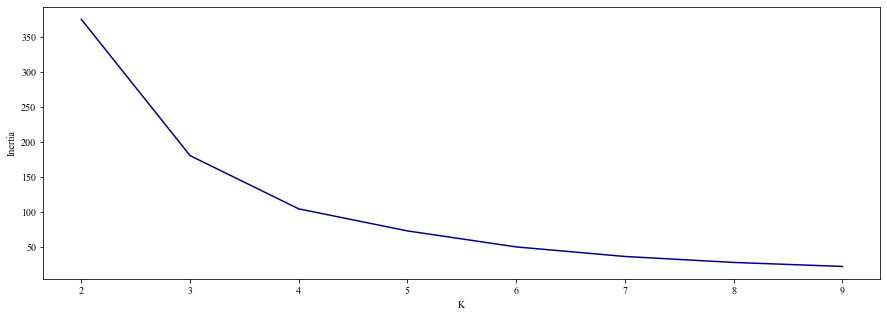

In [225]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias, c='darkblue')
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

In [298]:
kmeans_spec_assign, centroids, _ = kmeans(Y, k=3, random_state=2, tot=1e-4, n_init=100) #n_clusters = 3

Kmeans run no. 1
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.3074168420312848
Iteration number: 3 - diff 0.0545954688282861
Iteration number: 4 - diff 0.026377044273365492
Iteration number: 5 - diff 0.019659763235559208
Iteration number: 6 - diff 0.009908594195546173
Iteration number: 7 - diff 0.0077827491983141345
Iteration number: 8 - diff 0.002141198964531475
Iteration number: 9 - diff 0.0016241880414629886
Iteration number: 10 - diff 0.00032487190746131926
Iteration number: 11 - diff 0.003274518536198215
Iteration number: 12 - diff 0.00432087714024067
Iteration number: 13 - diff 0.0019887802148849327
Current best inertia: 180.63902774948698
Kmeans run no. 2
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.36177300480000507
Iteration number: 3 - diff 0.052611198587108776
Iteration number: 4 - diff 0.027593518556505867
Iterat

Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.33922302552140526
Iteration number: 3 - diff 0.11721631644255823
Iteration number: 4 - diff 0.0561968120091843
Iteration number: 5 - diff 0.05513925337213866
Iteration number: 6 - diff 0.04563356757059129
Iteration number: 7 - diff 0.05955245415612154
Iteration number: 8 - diff 0.059483170520175266
Iteration number: 9 - diff 0.04191369882860289
Iteration number: 10 - diff 0.029889668746725925
Iteration number: 11 - diff 0.029466973399064213
Iteration number: 12 - diff 0.016426880126748023
Iteration number: 13 - diff 0.009358222304280519
Iteration number: 14 - diff 0.006300200669725455
Iteration number: 15 - diff 0.001622959429084637
Iteration number: 16 - diff 0.0006504645185752131
Iteration number: 17 - diff 0.003274518536198215
Iteration number: 18 - diff 0.00432087714024067
Iteration number: 19 - diff 0.0019887802148849327
Kmeans run no. 20
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number:

Kmeans run no. 37
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.24205076236899253
Iteration number: 3 - diff 0.05920499836247024
Iteration number: 4 - diff 0.030705155868194327
Iteration number: 5 - diff 0.012519215670042579
Iteration number: 6 - diff 0.008559882490482975
Iteration number: 7 - diff 0.00618817541564651
Iteration number: 8 - diff 0.0006679416262344625
Kmeans run no. 38
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.36494479085213927
Iteration number: 3 - diff 0.0277755568836663
Iteration number: 4 - diff 0.01129097951283693
Iteration number: 5 - diff 0.008904795105530137
Iteration number: 6 - diff 0.005858175989219353
Iteration number: 7 - diff 0.0010001301299566974
Iteration number: 8 - diff 0.00033591850535382
Kmeans run no. 39
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - 

Iteration number: 24 - diff 0.003274518536198215
Iteration number: 25 - diff 0.00432087714024067
Iteration number: 26 - diff 0.0019887802148849327
Kmeans run no. 54
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.15221682627014688
Iteration number: 3 - diff 0.012143512158452779
Iteration number: 4 - diff 0.003382889120024744
Iteration number: 5 - diff 0.00033591850535382
Kmeans run no. 55
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.3564386898220589
Iteration number: 3 - diff 0.12464786929027236
Iteration number: 4 - diff 0.06970143200091627
Iteration number: 5 - diff 0.06779332741043947
Iteration number: 6 - diff 0.0668769283522253
Iteration number: 7 - diff 0.052771289576303254
Iteration number: 8 - diff 0.05308115454681914
Iteration number: 9 - diff 0.0582083597274022
Iteration number: 10 - diff 0.06072079700297449
Iteration

Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.5175224588613676
Iteration number: 3 - diff 0.09607263452186843
Iteration number: 4 - diff 0.06776262602984534
Iteration number: 5 - diff 0.03353526609128325
Iteration number: 6 - diff 0.03211935889574177
Iteration number: 7 - diff 0.01348245782979174
Iteration number: 8 - diff 0.009683331177100608
Iteration number: 9 - diff 0.005657991433359599
Iteration number: 10 - diff 0.001622959429084637
Iteration number: 11 - diff 0.0006504645185752131
Iteration number: 12 - diff 0.003274518536198215
Iteration number: 13 - diff 0.00432087714024067
Iteration number: 14 - diff 0.0019887802148849327
Kmeans run no. 71
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.5309762428963714
Iteration number: 3 - diff 0.26848268962955785
Iteration number: 4 - diff 0.22132377681612234
Iteration number: 5 - d

Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.17632581701840683
Iteration number: 3 - diff 0.07395588509877399
Iteration number: 4 - diff 0.04155568516308242
Iteration number: 5 - diff 0.02887319356658659
Iteration number: 6 - diff 0.011144795579483443
Iteration number: 7 - diff 0.004677883195452451
Iteration number: 8 - diff 0.005192223984231754
Iteration number: 9 - diff 0.00033591850535382
Kmeans run no. 92
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.6185358631683131
Iteration number: 3 - diff 0.07967180597428432
Iteration number: 4 - diff 0.01197021487499213
Iteration number: 5 - diff 0.003583018950802457
Iteration number: 6 - diff 0.001326565951858467
Kmeans run no. 93
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.33891304911979847
Iteration number: 3 - diff 0.12418505143044514
Iteration number: 4 - d

In [229]:
labels = df.drop(removed_idx).label.replace({'ham':0, 'spam':1}).values
performance_metrics(Y, kmeans_spec_assign, labels)

ARI: 0.676
NMI: 0.494
DBI: 0.489




# Visualizations
In this notebook the best obtained clustering results wil be visualised and analysed in more depth.

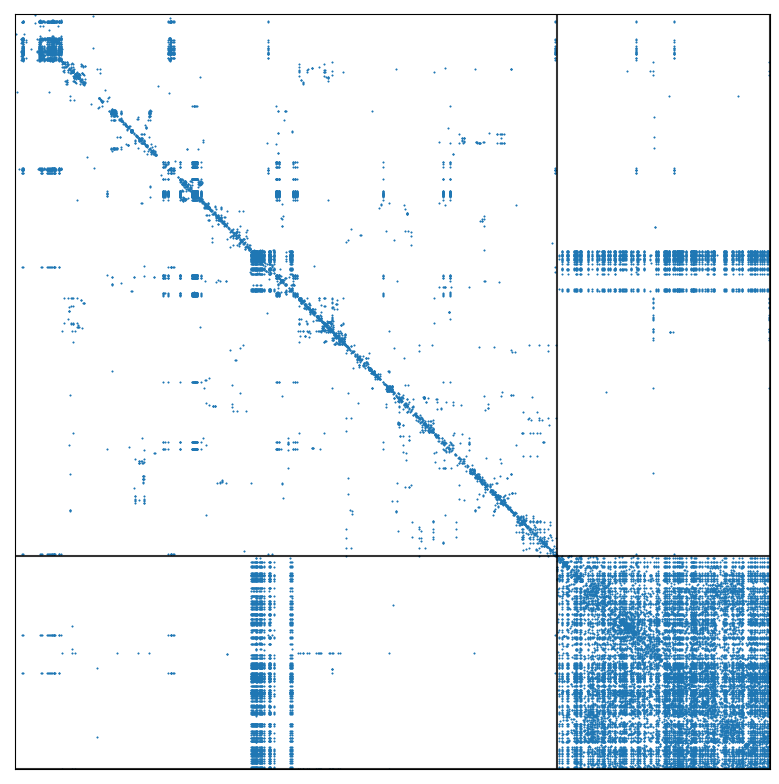

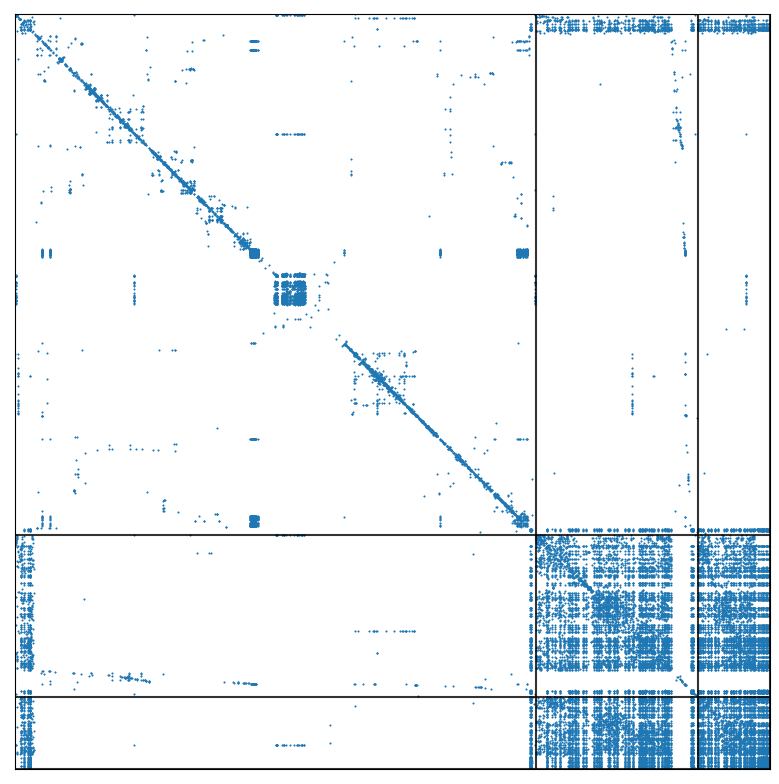

In [314]:
new_order = labels.argsort()

_, group_len = np.unique(labels, return_counts=True)


D = A_reduced[:, new_order][new_order]

fig, (ax1) = plt.subplots(figsize=(10,10), dpi=100)
ax1.spy(D, precision=0.5, markersize=0.5)
#ax1.spy(D[:group_len[0], :group_len[0]], color='blue')
#ax1.spy(D[group_len[1]:, group_len[1]:], color='red')
ax1.set_xticks([])
ax1.set_yticks([])
#ax1.set_title("Pairwise Cosine Similarity \n reordered by ground truth")

###From Nakis:
y = labels
N = A_reduced.shape[0]
counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)
###

fig.savefig('sim_matrix_ground_truth.png', dpi=100)

fig, (ax2) = plt.subplots(figsize=(10,10), dpi=100)

#sim_matrix = X.T@X
#new_order = kmeans_spec_assign.argsort()
#new_order = 
freq = np.flip(np.argsort(np.bincount(kmeans_spec_assign))[-(np.unique(kmeans_spec_assign).size):])
new_order = np.hstack((np.where(kmeans_spec_assign==freq[0])[0], 
                       np.where(kmeans_spec_assign==freq[1])[0],
                       np.where(kmeans_spec_assign==freq[2])[0]))

D = A[:, new_order][new_order]



#cmap = {0:'red', 1:'blue'}
#c=[cmap[i] for i in label]

ax2.spy(D, precision=0.5, markersize=0.5)
ax2.set_xticks([])
ax2.set_yticks([])

y = kmeans_spec_assign
#N = A_reduced.shape[0]
N = len(y)
counts=np.unique(y,return_counts=True)[1][freq]
counts_j=np.unique(y, return_counts=True)[1][freq]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=0.8)
    ax2.add_line(line)

for i in range(cum_j.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=0.8)
    ax2.add_line(line)

#ax2.set_title("Pairwise Cosine Similarity \n reordered by community assignment")
fig.savefig('sim_matrix_email_v2.png', dpi=100)
plt.show()

In [292]:
kmeans_spec_assign, centroids, _ = kmeans(Y, k=2, random_state=2, tot=1e-4, n_init=100) #n_clusters = 3

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.5614827815198409
Iteration number: 3 - diff 0.03160761968652769
Iteration number: 4 - diff 0.01620250063569494
Iteration number: 5 - diff 0.010797875090794388
Iteration number: 6 - diff 0.00393261607398897
Iteration number: 7 - diff 0.002241811326435103
Iteration number: 8 - diff 0.001119036558438922
Current best inertia: 375.6816673955688
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.4661905238227713
Iteration number: 3 - diff 0.14155178491120407
Iteration number: 4 - diff 0.09361974636608009
Iteration number: 5 - diff 0.05117017413471655
Iteration number: 6 - diff 0.03160761968652769
Iteration number: 7 - diff 0.01620250063569494
Iteration number: 8 - diff 0.010797875090794388
Iteration number: 9 - diff 0.00393261607398897
Iteration number: 10 - diff 0.002241811326435103
Iteration number: 11 - diff 0.001119

Iteration number: 6 - diff 0.024811780039202334
Iteration number: 7 - diff 0.014425623289674302
Iteration number: 8 - diff 0.011339952253924587
Iteration number: 9 - diff 0.0033682975237438024
Iteration number: 10 - diff 0.002238411716988139
Kmeans run no. 29
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.3184185912863808
Iteration number: 3 - diff 0.27792507952151163
Iteration number: 4 - diff 0.27303819398516843
Iteration number: 5 - diff 0.16666957034280078
Iteration number: 6 - diff 0.07425386994093344
Iteration number: 7 - diff 0.04761225074531895
Iteration number: 8 - diff 0.036232360578601644
Iteration number: 9 - diff 0.01774970230673645
Iteration number: 10 - diff 0.010409691909521148
Iteration number: 11 - diff 0.003876466508636176
Iteration number: 12 - diff 0.0016625644086747486
Iteration number: 13 - diff 0.0011095624065769272
Iteration number: 14 - diff 0.0011113736801815432
Iteration number: 15 - diff 0.0005555191726127573

Iteration number: 8 - diff 0.010797875090794388
Iteration number: 9 - diff 0.00393261607398897
Iteration number: 10 - diff 0.002241811326435103
Iteration number: 11 - diff 0.001119036558438922
Kmeans run no. 53
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.4362464337302886
Iteration number: 3 - diff 0.06234981016259353
Iteration number: 4 - diff 0.04006363723501586
Iteration number: 5 - diff 0.03082025610384883
Iteration number: 6 - diff 0.015095917725706341
Iteration number: 7 - diff 0.01097130263546718
Iteration number: 8 - diff 0.0033246639465571346
Iteration number: 9 - diff 0.002219565921298841
Iteration number: 10 - diff 0.0011113736801815432
Iteration number: 11 - diff 0.0005555191726127573
Kmeans run no. 54
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.42313268996784337
Iteration number: 3 - diff 0.06614979610201323
Iteration number: 4 - diff 0.04319306789448568
Iteration number:

Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.31661654895958236
Iteration number: 3 - diff 0.14353055219472857
Iteration number: 4 - diff 0.08120524986227391
Iteration number: 5 - diff 0.04447506588351004
Iteration number: 6 - diff 0.028561180267231184
Iteration number: 7 - diff 0.01620250063569494
Iteration number: 8 - diff 0.010797875090794388
Iteration number: 9 - diff 0.00393261607398897
Iteration number: 10 - diff 0.002241811326435103
Iteration number: 11 - diff 0.001119036558438922
Kmeans run no. 79
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.32587631997134586
Iteration number: 3 - diff 0.18814167729573464
Iteration number: 4 - diff 0.08452382209081732
Iteration number: 5 - diff 0.04797648986183899
Iteration number: 6 - diff 0.03727906156325534
Iteration number: 7 - diff 0.021352357868660347
Iteration number: 8 - diff 0.011444019226526086
Iteration number: 9 - diff 0.007181701114725877
Iteration number: 10 - d

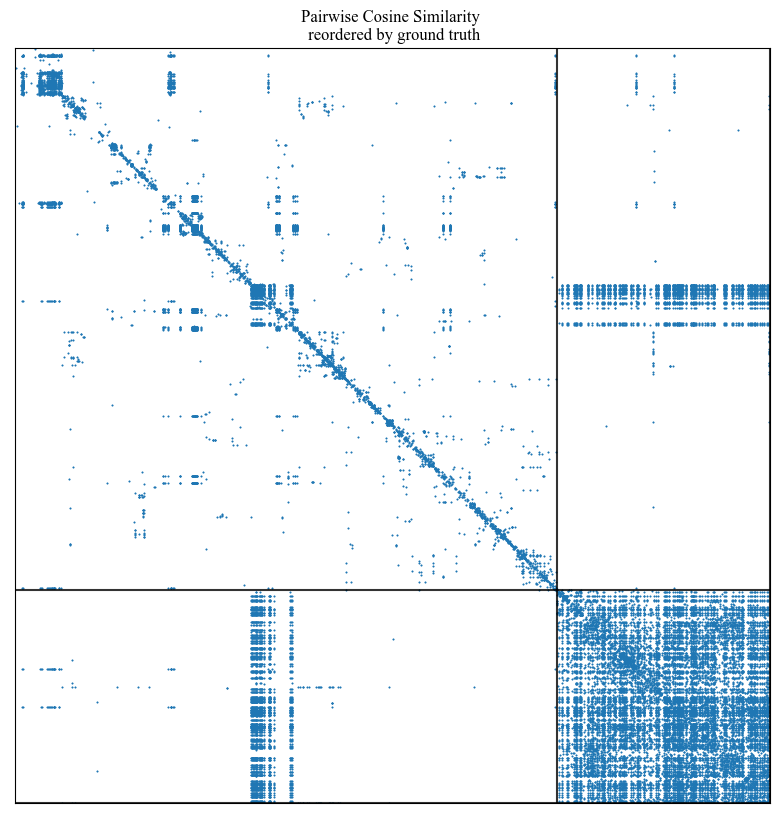

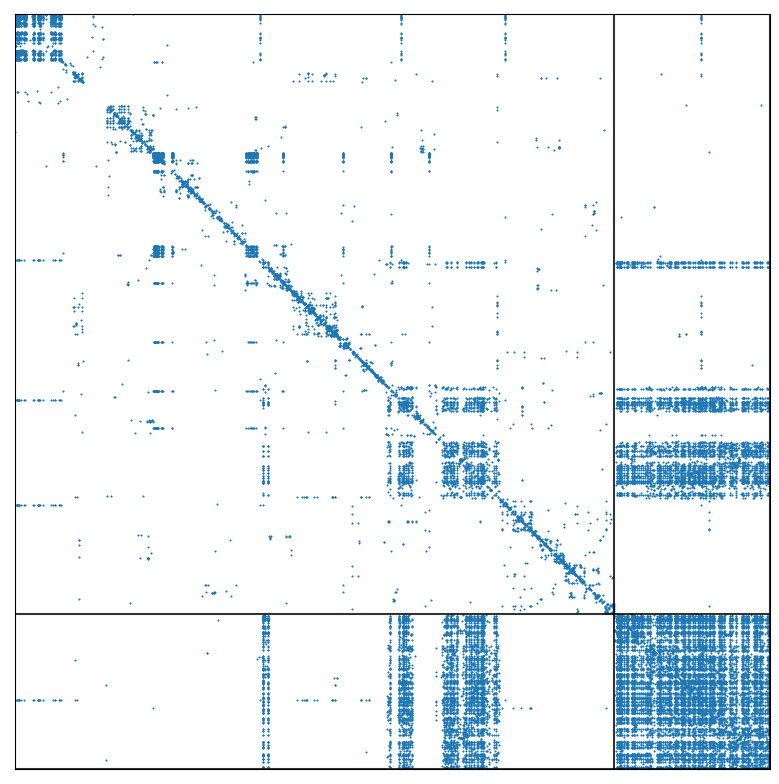

In [297]:
new_order = labels.argsort()

_, group_len = np.unique(labels, return_counts=True)


D = A_reduced[:, new_order][new_order]

fig, (ax1) = plt.subplots(figsize=(10,10), dpi=100)
ax1.spy(D, precision=0.5, markersize=0.5)
#ax1.spy(D[:group_len[0], :group_len[0]], color='blue')
#ax1.spy(D[group_len[1]:, group_len[1]:], color='red')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Pairwise Cosine Similarity \n reordered by ground truth")

###From Nakis:
y = labels
N = A_reduced.shape[0]
counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)
###

fig, ax2 = plt.subplots(figsize=(10,10), dpi=100)

#sim_matrix = X.T@X
new_order = kmeans_spec_assign.argsort()
#new_order = 
#freq = np.flip(np.argsort(np.bincount(kmeans_spec_assign))[-(np.unique(kmeans_spec_assign).size):])
#new_order = np.hstack((np.where(kmeans_spec_assign==freq[0])[0], 
#                       np.where(kmeans_spec_assign==freq[1])[0]))

D = A[:, new_order][new_order]



#cmap = {0:'red', 1:'blue'}
#c=[cmap[i] for i in label]

ax2.spy(D, precision=0.5, markersize=0.5)
ax2.set_xticks([])
ax2.set_yticks([])

y = kmeans_spec_assign
N = A_reduced.shape[0]
counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=0.8)
    ax2.add_line(line)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=0.8)
    ax2.add_line(line)

#ax2.set_title("Pairwise Cosine Similarity \n reordered by community assignment")
fig.savefig('sim_matrix_email_v1.png')
plt.show()

## PCA

In [17]:
from sklearn import decomposition

In [22]:
X_reduced = np.delete(X.toarray(), removed_idx, axis=0)
pca = decomposition.PCA(n_components=2)
pca.fit(X_reduced)
pca_emb= pca.transform(X_reduced)

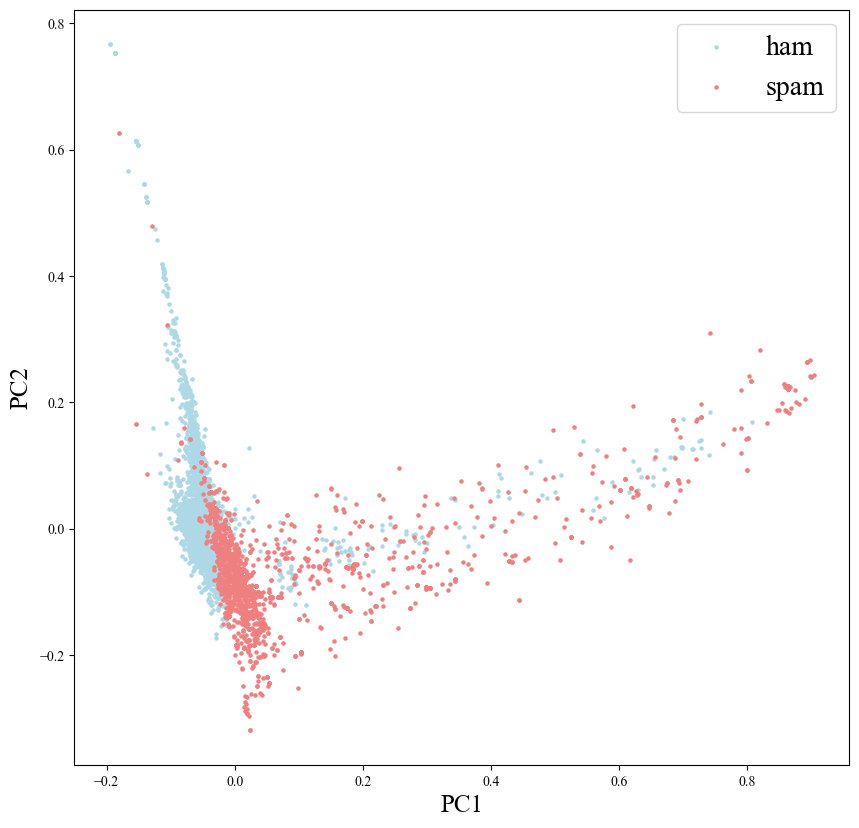

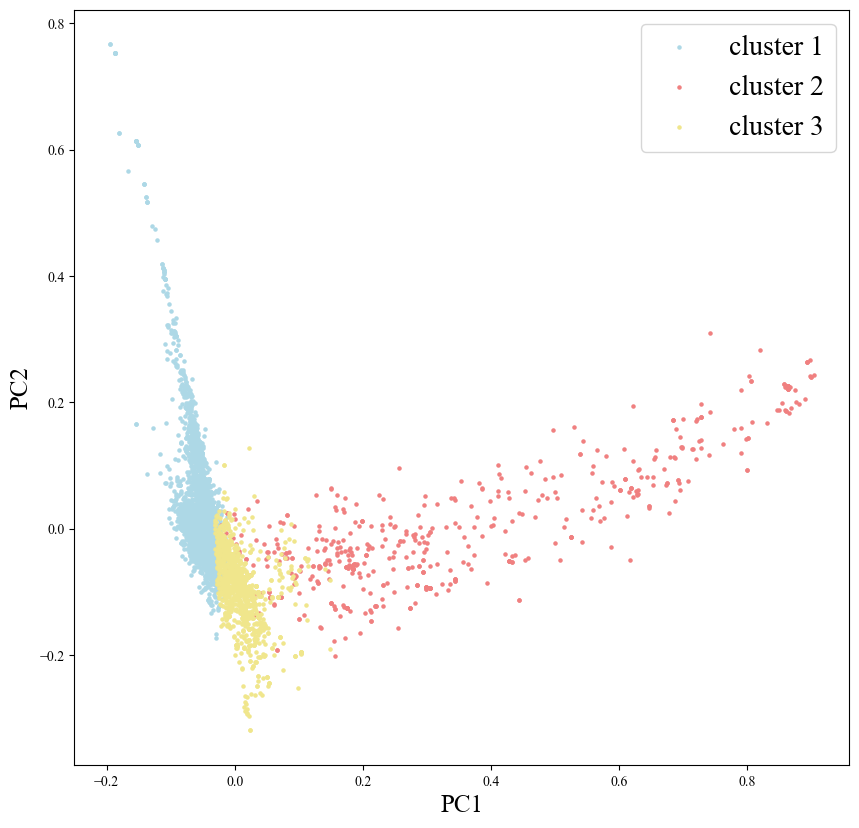

In [323]:
ham_idx = np.where(labels==0)[0]
spam_idx = np.where(labels==1)[0]


fig, ax1 = plt.subplots(figsize=(10,10), dpi=100)
clust1 = np.where(kmeans_spec_assign==0)[0]
clust2 = np.where(kmeans_spec_assign==1)[0]
clust3 = np.where(kmeans_spec_assign==2)[0]

ax1.scatter(pca_emb[:,0][ham_idx], 
            pca_emb[:,1][ham_idx],
            c='lightblue',
            s=5,
            label='ham')
ax1.scatter(pca_emb[:,0][spam_idx], 
            pca_emb[:,1][spam_idx],
            c='lightcoral',
            s=5,
            label='spam')

ax1.set_xlabel('PC1', fontsize=18)
ax1.set_ylabel('PC2', fontsize=18)
#ax1.set_title('Ground truth')

ax1.legend(prop={'size': 20})
fig.savefig('pca_embedding_ground_truth.png', dpi=100)

fig, ax2 = plt.subplots(figsize=(10,10), dpi=100)

ax2.scatter(pca_emb[:,0][clust2], 
            pca_emb[:,1][clust2],
            c='lightblue',
            s=5,
            label='cluster 1')
ax2.scatter(pca_emb[:,0][clust1], 
            pca_emb[:,1][clust1],
            c='lightcoral',
            s=5,
            label='cluster 2')
ax2.scatter(pca_emb[:,0][clust3], 
            pca_emb[:,1][clust3],
            c='khaki',
            s=5,
            label='cluster 3')

ax2.set_xlabel('PC1', fontsize=18)
ax2.set_ylabel('PC2', fontsize=18)
#ax2.set_title('Community assignment')
legend = ax2.legend(prop={'size': 20})
fig.savefig('pca_embedding_community.png', dpi=100)
plt.show()

## UMAP

In [38]:
import umap.umap_ as umap

In [39]:
X_umap = umap.UMAP(metric='cosine').fit_transform(X_reduced)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 14 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


In [64]:
NaN_idx = np.argwhere(np.isnan(X_umap))
X_umap = X_umap[~np.isnan(X_umap).any(axis=1)]

In [65]:
rows_dropped = np.unique(NaN_idx[:,0])

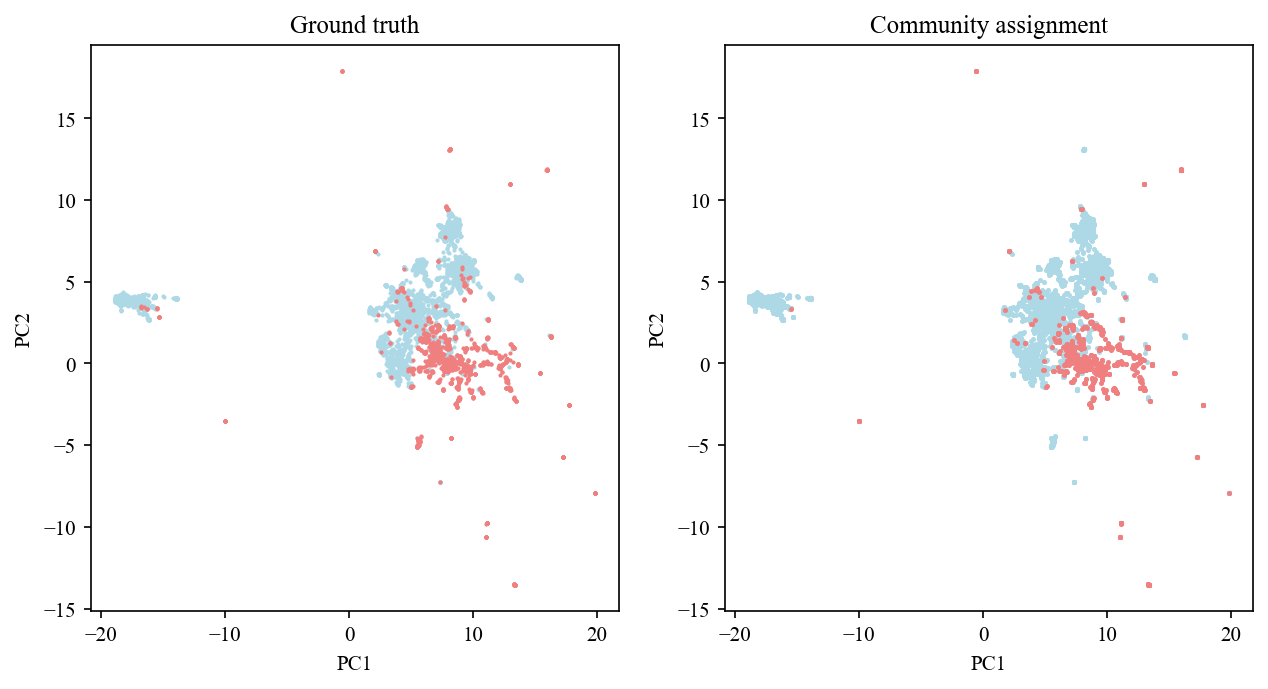

In [71]:
labels_umap = df.drop(removed_idx).drop(rows_dropped).label.replace({'ham':0, 'spam':1}).values
ham_idx = np.where(labels_umap==0)[0] 
spam_idx = np.where(labels_umap==1)[0]

assign_umap = np.delete(kmeans_spec_assign, rows_dropped)
clust1 = np.where(assign_umap==0)[0]
clust2 = np.where(assign_umap==1)[0]


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=150)

ax1.scatter(X_umap[:,0][ham_idx], 
            X_umap[:,1][ham_idx],
            c='lightblue',
            s=1)
ax1.scatter(X_umap[:,0][spam_idx], 
            X_umap[:,1][spam_idx],
            c='lightcoral',
            s=1)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

ax1.set_title('Ground truth')

ax2.scatter(X_umap[:,0][clust1], 
            X_umap[:,1][clust1],
            c='lightblue',
            s=2)
ax2.scatter(X_umap[:,0][clust2], 
            X_umap[:,1][clust2],
            c='lightcoral',
            s=2)

ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

ax2.set_title('Community assignment')

plt.show()

## TSNE

In [43]:
X_umap.T[:,0].shape

(2,)

# Analysing misclassifications

In [325]:
np.unique(kmeans_spec_assign, return_counts=True)

(array([0, 1, 2]), array([ 528, 3800, 1179]))

By inspecting the visualisations of the clusters both in the PCA figures and the reordered pairwise similarity/affinity matrix, it seems as if the spectral clustering algorithmm have identified three clusters. One of which is mainly composed of ham mails, while the other two appear to be composed of spam mails. As a first step let us validate these indications:

In [327]:
clust1_dist = np.unique(labels[np.where(kmeans_spec_assign==0)[0]], return_counts=True)
clust2_dist = np.unique(labels[np.where(kmeans_spec_assign==1)[0]], return_counts=True)
clust3_dist = np.unique(labels[np.where(kmeans_spec_assign==2)[0]], return_counts=True)

In [328]:
clust1_dist

(array([0, 1]), array([ 98, 430]))

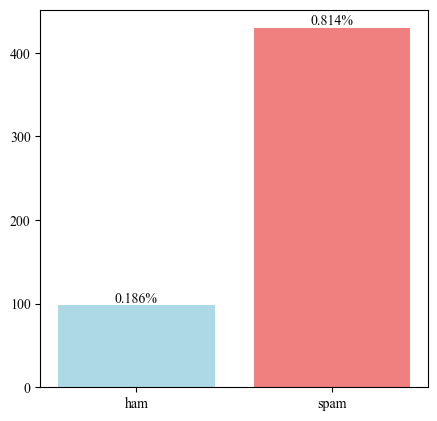

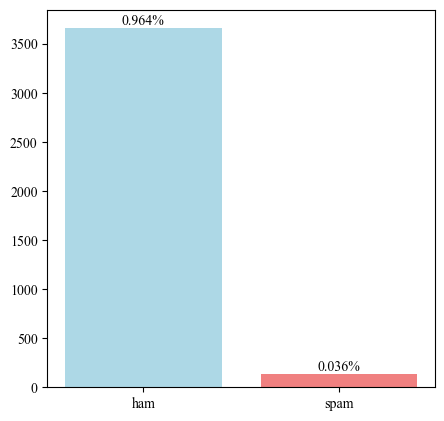

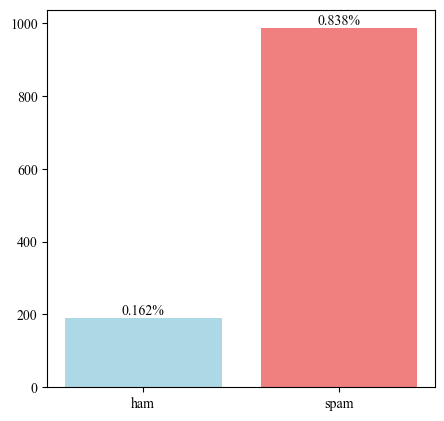

In [335]:

for dist in [clust1_dist, clust2_dist, clust3_dist]:
    fig, ax = plt.subplots(figsize=(5,5), dpi=100)
    bar = ax.bar(['ham', 'spam'], dist[1], color=['lightblue', 'lightcoral'])
    
    # Add counts above the two bar graphs
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height/(np.sum(dist[1])):.3f}%', ha='center', va='bottom')

    plt.show()

The above illustrations verify the earlier indications.

As the next step in our analysis we will take a deeper look into where the classifications go wrong, and try to deduce why the misclassification might occur. First we will look into the non identified spam mails, that have been assigned to cluster with a majority of ham mails.

In [385]:
idx = np.where(kmeans_spec_assign==1)[0]
clust2 = labels[idx]

In [386]:
idx

array([   1,    2,    4, ..., 5500, 5502, 5505])

In [387]:
np.where(clust2==1)[0], len(np.where(clust2==1)[0])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136]),
 137)

Notice that there is 137 spam mails.

In [388]:
idx[np.where(clust2==1)[0]]

array([   1,    2,    4,   12,   19,   23,   28,   34,   39,   66,   67,
         72,   83,   99,  100,  114,  116,  121,  126,  128,  129,  133,
        185,  192,  196,  197,  210,  221,  228,  245,  246,  247,  248,
        250,  251,  252,  253,  254,  255,  273,  275,  291,  300,  302,
        305,  310,  313,  316,  344,  377,  385,  415,  570,  586,  604,
        633,  674,  675,  676,  677,  678,  679,  683,  688,  715,  757,
        759,  790,  950,  988,  989, 1006, 1014, 1019, 1020, 1039, 1040,
       1041, 1065, 1072, 1074, 1076, 1077, 1081, 1082, 1092, 1098, 1105,
       1107, 1118, 1159, 1160, 1180, 1183, 1184, 1215, 1240, 1243, 1262,
       1263, 1265, 1272, 1282, 1291, 1294, 1296, 1306, 1309, 1313, 1314,
       1316, 1319, 1320, 1329, 1330, 1334, 1353, 1369, 1379, 1383, 1389,
       1402, 1407, 1415, 1422, 1438, 1454, 1456, 1466, 1481, 1485, 1492,
       1520, 1523, 1527, 1540, 1547])

In [389]:
feature_names = vectorizer.get_feature_names_out()
TDM = pd.DataFrame(X_reduced, columns=feature_names).dropna()

In [390]:
miss_classified = TDM.iloc[idx[np.where(clust2==1)[0]], :]

In [391]:
from wordcloud import WordCloud
clust_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(miss_classified.T.sum(axis=1))

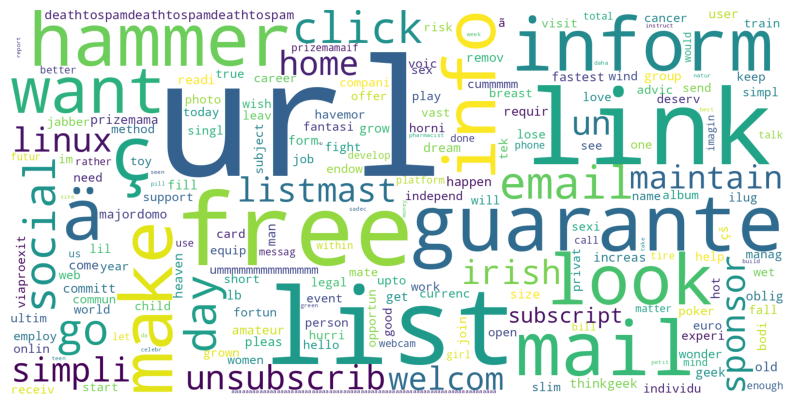

In [392]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(clust_cloud)
ax.axis("off")
#ax.set_title('TFIDF weighted words \n Missclassified SPAM')
plt.savefig('wordcloud_miss_spam.png',dpi=100)
plt.show()

It definitely stands out as SPAM. We will try to go through a few examples:

In [357]:
miss_classified_text = df.drop(removed_idx).iloc[idx[np.where(clust2==1)[0]],:].text.values

In [358]:
miss_classified_text[0]

"1) Fight The Risk of Cancer!\nhttp://www.adclick.ws/p.cfm?o=315&s=pk0072) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\nhttp://www.adclick.ws/p.cfm?o=249&s=pk0073) Get the Child Support You Deserve - Free Legal Advice\nhttp://www.adclick.ws/p.cfm?o=245&s=pk0024) Join the Web's Fastest Growing Singles Community\nhttp://www.adclick.ws/p.cfm?o=259&s=pk0075) Start Your Private Photo Album Online!\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007Have a Wonderful Day,\nOffer Manager\nPrizeMamaIf you wish to leave this list please use the link below.\nhttp://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258\n--\nIrish Linux Users' Group: ilug@linux.ie\nhttp://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.\nList maintainer: listmaster@linux.ie"

In [359]:
miss_classified_text[1]

"1) Fight The Risk of Cancer!\nhttp://www.adclick.ws/p.cfm?o=315&s=pk0072) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\nhttp://www.adclick.ws/p.cfm?o=249&s=pk0073) Get the Child Support You Deserve - Free Legal Advice\nhttp://www.adclick.ws/p.cfm?o=245&s=pk0024) Join the Web's Fastest Growing Singles Community\nhttp://www.adclick.ws/p.cfm?o=259&s=pk0075) Start Your Private Photo Album Online!\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007Have a Wonderful Day,\nOffer Manager\nPrizeMamaIf you wish to leave this list please use the link below.\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417"

In [360]:
miss_classified_text[2]

"I thought you might like these:\n1) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\nhttp://www.freeyankee.com/cgi/fy2/to.cgi?l=822slim12) Fight The Risk of Cancer!\nhttp://www.freeyankee.com/cgi/fy2/to.cgi?l=822nic1 3) Get the Child Support You Deserve - Free Legal Advice\nhttp://www.freeyankee.com/cgi/fy2/to.cgi?l=822ppl1Offer Manager\nDaily-Deals\nIf you wish to leave this list please use the link below.\nhttp://www.qves.com/trim/?social@linux.ie%7C29%7C134077\n--\nIrish Linux Users' Group Social Events: social@linux.ie\nhttp://www.linux.ie/mailman/listinfo/social for (un)subscription information.\nList maintainer: listmaster@linux.ie"

In [362]:
miss_classified_text[30]

"\n       Socijalisticka partija Srbije, predvodjena grupom starih socijalista na celu sa Milomirem Minicem, konacno se odrekla politike i herojskog drzanja predsednika te stranke Slobodana Milosevica, saopstenjima, da jedan ,,slabo obavesten covek ne moze, pogotovu ne iz zatvorske celije upravljati tako velikom partijom kao sto je Socijalisticka partija Srbije, pa zvao se on i Slobodan Milosevic''.\n       Socijalisti koji za sebe danas kazu da vise nisu idolopoklonici Slobodana Milosevica, neprestano, u kontaktima sa clanovima i simpatizerima te partije, pokusavaju da razdvoje odbranu Slobodana Milosevica u Hagu, od politickog zivota u Srbiji, pripisujuci Milosevicevim braniocima iz nacionalnog komiteta za oslobadjanje S. Milosevica, ,,Sloboda'' da im je cilj da uniste Socijalisticku partiju Srbije.\n        Iako je zbog istih takvih gledista, svojevremeno najpolularniji socijalista, posle predsednika te stranke, prof. Branislav Ivkovic bio iskljucen iz redova SPS, danas rukovodstvo 

In [363]:
miss_classified_text[25]

'\nGREEN CARD\nfunction Go()\n{\nwindow.location="http://www.yesilkart.org/index.php?Who=19";\n}\n\n-------------------------------------------------------\nThis sf.net email is sponsored by: OSDN - Tired of that same old\ncell phone?  Get a new here for FREE!\nhttps://www.inphonic.com/r.asp?r=sourceforge1&refcode1=vs3390\n_______________________________________________\nwebmake-talk mailing list\nwebmake-talk@lists.sourceforge.net\nhttps://lists.sourceforge.net/lists/listinfo/webmake-talk\n'

In [364]:
miss_classified_text[60]

'\nHello I am your hot lil horny toy.\n    I am the one you dream About,\n    I am a very open minded person,\n    Love to talk about and any subject.\n    Fantasy is my way of life,\n    Ultimate in sex play.     Ummmmmmmmmmmmmm\n     I am Wet and ready for you.     It is not your looks but your imagination that matters most,\n     With My sexy voice I can make your dream come true...\n\n     Hurry Up! call me let me Cummmmm for you..........................\nTOLL-FREE:             1-877-451-TEEN (1-877-451-8336)For phone billing:     1-900-993-2582\n--\n_______________________________________________\nSign-up for your own FREE Personalized E-mail at Mail.com\nhttp://www.mail.com/?sr=signup'

A possible explanation of the algorithm's shortcoming can be our approach to handle URL links, given that the wordcloud of the TFIDF weighted words highlights the importance of words such as URL or link among the missclasified spam mails. Let us try to investigate the amount of URLs:

In [366]:
import re
tot_urls = 0
for text in miss_classified_text:
    tot_urls += len(re.findall(r'(https?://[^\s]+)', text))

In [368]:
print(f'The average number of URLs: {tot_urls/len(miss_classified_text):.2f}')

The average number of URLs: 3.11


Let us compare this number to the two other clusters:

In [397]:
clust1 = labels[np.where(kmeans_spec_assign == 0)[0]]
clust3 = labels[np.where(kmeans_spec_assign == 2)[0]]

for clust in [clust1, clust3]:
    temp_text = df.drop(removed_idx).iloc[idx[np.where(clust==1)[0]],:].text.values

    tot_urls = 0
    for text in temp_text:
        tot_urls += len(re.findall(r'(https?://[^\s]+)', text))
    print(f'The average number of URLs: {tot_urls/len(temp_text):.2f}')

The average number of URLs: 2.46
The average number of URLs: 1.52


Interestingly, one can see that there on average is more links/URLs in the missclassified spam than in the correctly identified spam. Hence, a possible explanation could in fact be that this shortcoming arises due to our initial manipulation of URLs.

A second thing we can look into is the ham mails being classified as spam:

In [398]:
miss_classified_ham_c1 = np.where(clust1==0)[0]
miss_classified_ham_c2 = np.where(clust3==0)[0]

In [399]:
miss_classified_c1 = TDM.iloc[idx[np.where(clust1==0)[0]], :]
miss_classified_c2 = TDM.iloc[idx[np.where(clust3==0)[0]], :]

In [400]:
clust1_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(miss_classified_c1.T.sum(axis=1))
clust2_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(miss_classified_c2.T.sum(axis=1))

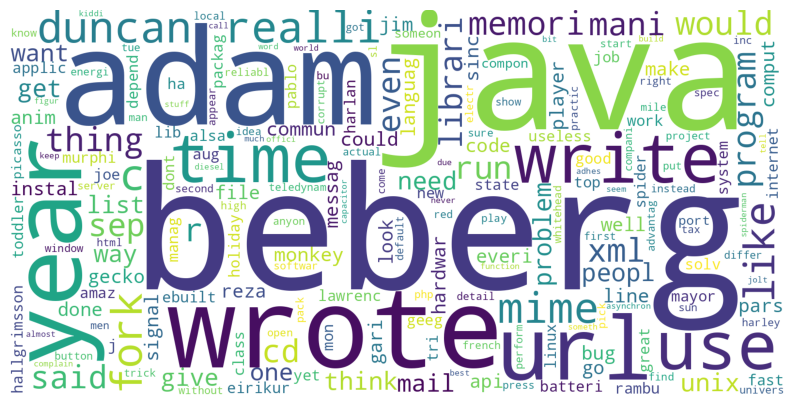

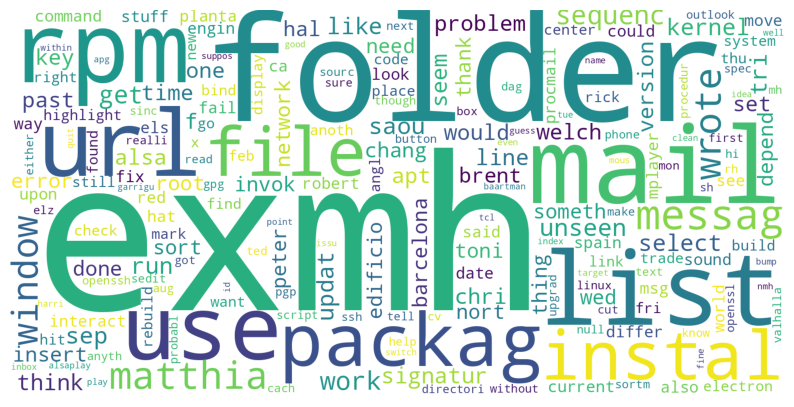

In [401]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(clust1_cloud)
ax.axis("off")
plt.savefig('wordcloud_miss_hamm_c1.png', dpi=100)
#ax.set_title('TFIDF weighted words \n Missclassified HAM (cluster 1)')
plt.show()

fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(clust2_cloud)
ax.axis("off")
#ax.set_title('TFIDF weighted words \n Missclassified HAM (cluster 3)')
#fig.tight_layout()
plt.savefig('wordcloud_miss_hamm_c2.png', dpi=100)
plt.show()

# Wordclouds for each cluster

In [379]:
clust1_idx = np.where(kmeans_spec_assign==0)[0]
clust2_idx = np.where(kmeans_spec_assign==1)[0]
clust3_idx = np.where(kmeans_spec_assign==2)[0]

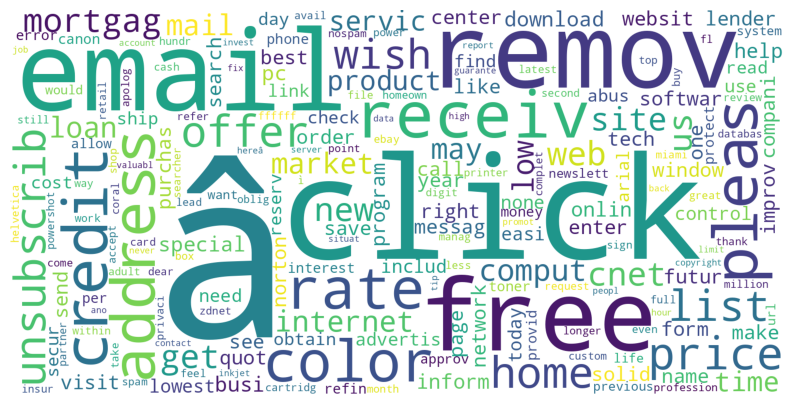

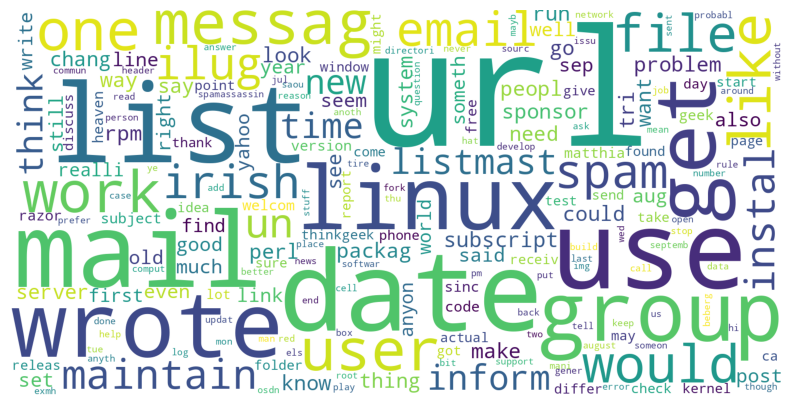

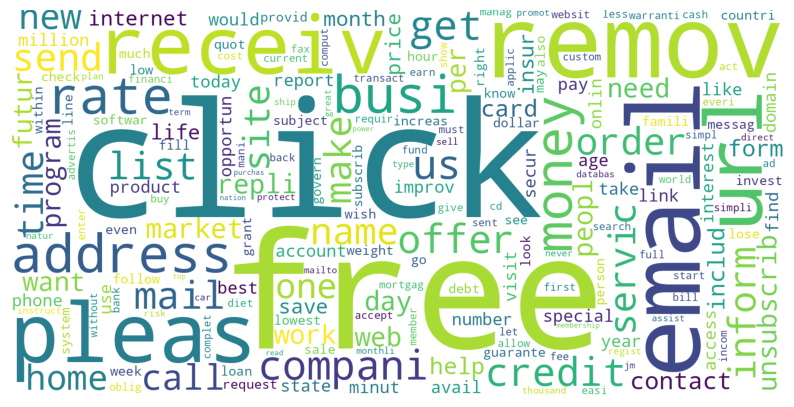

In [383]:
for i, clust in enumerate([clust1_idx, clust2_idx, clust3_idx]):
    miss_classified = TDM.iloc[clust,:]
    clust_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(miss_classified.T.sum(axis=1))
    
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    ax.imshow(clust_cloud)
    ax.axis("off")
    #ax.set_title(f'TFIDF weighted words: cluster {i}')
    plt.savefig(f'wordcloud_cluster_{i+1}.png',dpi=100)
    plt.show()